In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [40]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
most_recent_date=session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

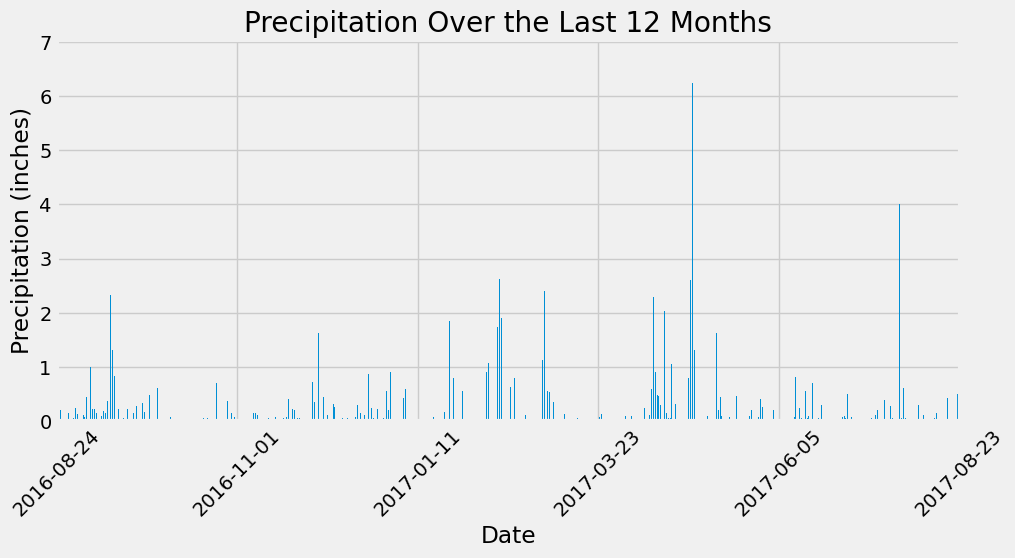

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date=dt.datetime(2016, 8, 23)
# Query to retrieve the data and precipitation scores
twelve_recent_date = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > date).\
    order_by(desc(Measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the column names
df = pd.DataFrame(twelve_recent_date, columns=['date', 'prcp'])

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(x='date', y='prcp', kind='bar', figsize=(10,6), legend=False)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Adjust x-axis to show only 5 evenly spaced date labels
x_labels = df['date'].values  # Get all the date values
ax.set_xticks([i for i in range(0, len(x_labels), len(x_labels)//5)])  # Select 5 evenly spaced ticks
ax.set_xticklabels(df['date'].dt.strftime('%Y-%m-%d').iloc[::len(x_labels)//5])  # Show date labels in 'YYYY-MM-DD' format

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary = df['prcp'].describe()
summary_table = pd.DataFrame(prcp_summary)

# Print the table
print(summary_table)

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [50]:
# Query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()

# Print the total count
print(station_count)

9


In [52]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (session.query(Station.station, func.count(Measurement.station).label('count'))
                   .join(Measurement, Station.station == Measurement.station)
                  .group_by(Station.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())
for station, count in active_stations:
    print(station,count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [54]:
# Define the most active station ID
station_id = 'USC00519281'

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
)
    .filter(Measurement.station == station_id)
    .all())

# Extract the results
min_temp, max_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Station ID: {station_id}")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


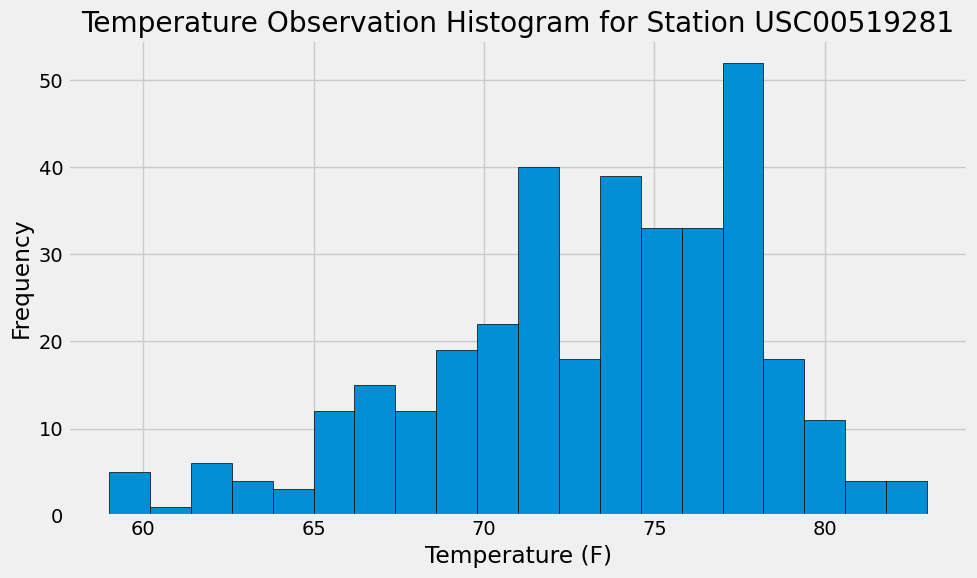

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Define the most active station ID
station_id = 'USC00519281'
# Fixed date and date range
start_date = dt.datetime(2016, 8, 23)
end_date = dt.datetime(2017, 8, 23)

# Query to retrieve the last 12 months of temperature observation data for the station
temperature_data = (session.query(Measurement.tobs)
                    .filter(Measurement.station == station_id)
                    .filter(Measurement.date.between(start_date, end_date))
                    .all())

# Convert the query result to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=20, edgecolor='black')
plt.title(f'Temperature Observation Histogram for Station {station_id}')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()